In [1]:
# Project_glass
!git clone https://github.com/Mike030668/Project_glass.git -q
# Genetic_generation_net
!git clone https://github.com/Mike030668/Genetic_generation_net.git -q
# установка библиотека контроля  времени
!pip install stopit -q


# imports

In [4]:
import sys
dir_glass = '/content/Project_glass'
dir_gen = '/content/Genetic_generation_net'
sys.path.append(dir_gen)
sys.path.append(dir_glass)

# Genetic_generation_net
from genetic.sowing import getnetfrombest
from block_net.constant import TIMELIMIT_1

# Project_glass
from prepare_data.const_predprice import  TARGET_COLS, BASE_COLS, MAKE_LOG_TARGET
from prepare_data.constants import GLASS_COLS, FUTURE, BATCH_SIZE, DEPTH, PREDICT_LAG, MAKE_LOG_VOL
from prepare_data.utils import future_sequence
import numpy as np # библиотека нампи
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
from IPython.display import clear_output # очистка вывода в ячейке
import joblib
import pandas as pd               # библиотека пандас
import tensorflow as tf           # библиотека машинного обучения

# load prepared train data

data prepared with vcs note makedata_vsc.ipynb

In [7]:
x_train_sc = np.load(dir_glass + "/predprice/x_train_sc.npy")
x_val_sc = np.load(dir_glass + "/predprice/x_val_sc.npy")
y_train_sc = np.load(dir_glass + "/predprice/y_train_sc.npy")
y_val_sc = np.load(dir_glass + "/predprice/y_val_sc.npy")

In [9]:
# Для генерации выборки временных рядов
TSG = tf.keras.preprocessing.sequence.TimeseriesGenerator

# Создаем генератор для обучения
train_datagen = TSG(x_train_sc, y_train_sc,          # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
val_datagen = TSG(x_val_sc, y_val_sc,                # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

print(train_datagen[0][0].shape,
      val_datagen[0][1].shape)

# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
DataGen = TSG(x_val_sc, y_val_sc,              # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_val_sc))   # Размер batch будет равен длине нашей выборки


# сформируем сами массивы для проверки
XVAL, YVAL = [], []
for i in DataGen:
  XVAL.append(i[0])
  YVAL.append(i[1])

# так как это список объектов
# мы вытаскиваем нужный нам
XVAL = np.array(XVAL)[0]
YVAL = np.array(YVAL)[0]
print(XVAL.shape,YVAL.shape)


# запомним входную размерность для модели обучения
INSHAPE = train_datagen[0][0].shape[1:]

(64, 32, 53) (64, 5)
(530, 32, 53) (530, 5)


## Генерация нейронки

In [11]:
directory = dir_glass + "/gen_price_models/"  # откуда берем для генерации
########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
# нужное количество входных нейроной
neiro_out = PREDICT_LAG

# функции активации для выходного слоя
activ_out = ['linear', 'tanh']

# загружаем список парамметров лучших сетей
save_nets = np.load(directory+'bestnets.npy', allow_pickle = True)

# генерируем список моделей в количестве n
set_models = getnetfrombest(
                            INSHAPE,
                            save_nets.tolist(),
                            activ_lays,
                            activ_out, neiro_out,
                            limit = TIMELIMIT_1,
                            n = 3)


In [12]:
k = 0 # указываем индекс от 0 до n-1 для выбора модели
gen_model = set_models[k]
gen_model.call = tf.function(gen_model.call)

# Отображение сводки модели
gen_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 53)]             0         []                            
                                                                                                  
 conv1d_transpose (Conv1DTr  (None, 32, 128)              13696     ['input_1[0][0]']             
 anspose)                                                                                         
                                                                                                  
 conv1d_transpose_1 (Conv1D  (None, 32, 128)              32896     ['conv1d_transpose[0][0]']    
 Transpose)                                                                                       
                                                                                              

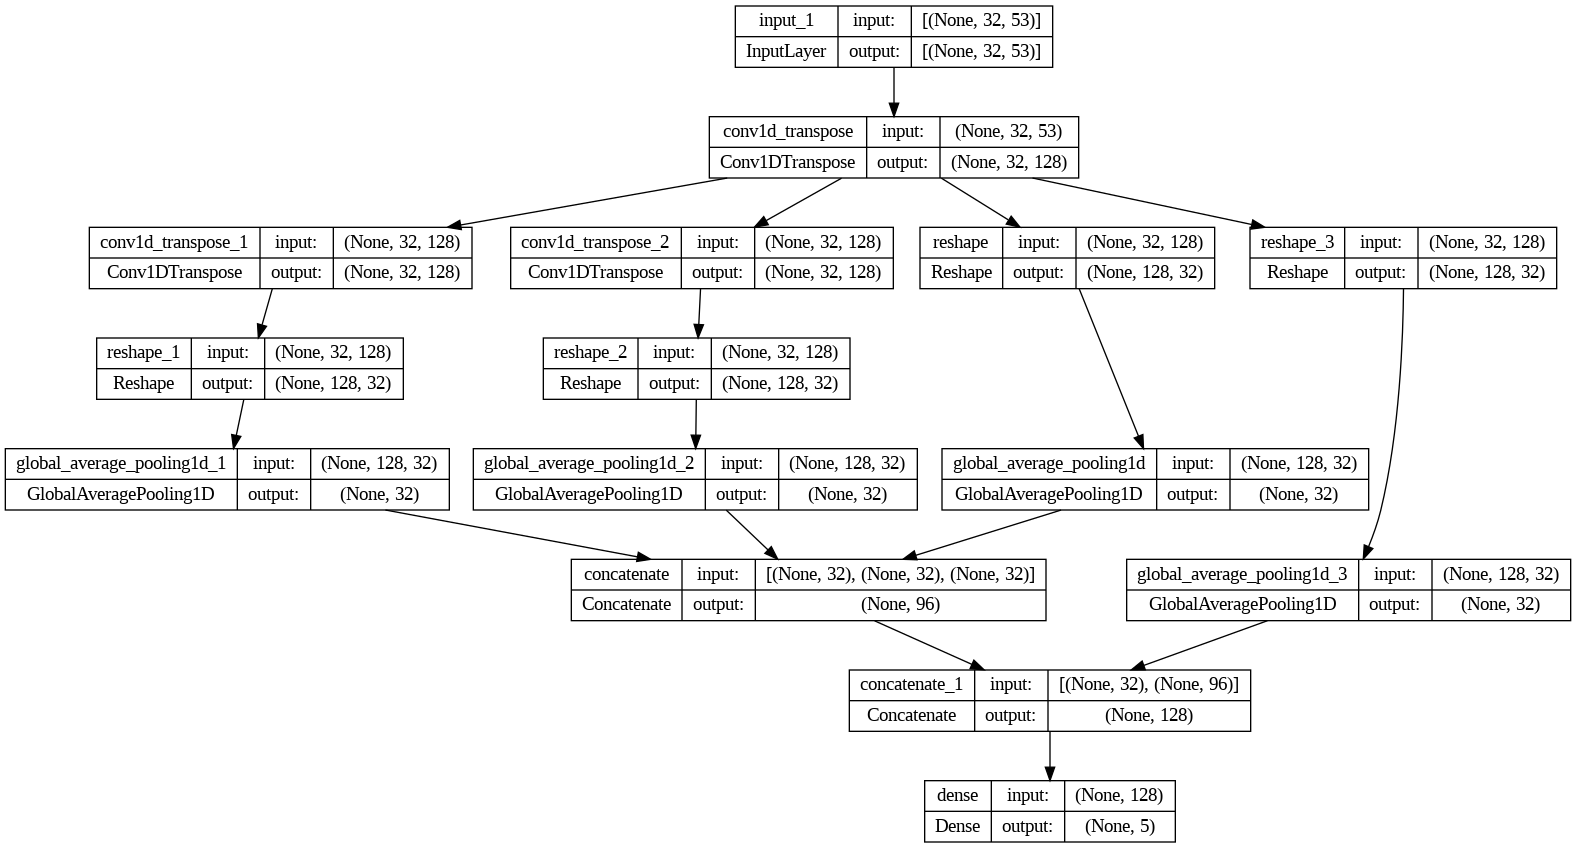

In [14]:
# дерево модели
tf.keras.utils.plot_model(gen_model, show_shapes=True)

In [17]:
# понижение шага
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8,
                                                 patience = 3,
                                                 min_lr = 1e-9,
                                                 verbose = 1)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

path_model = dir_glass + "/Project_glass/predprice/model_gen" # Если в Colab то вновь обученная сетка запишется во временную папку в Colab

# Сохранение модели
checkpoint  = tf.keras.callbacks.ModelCheckpoint(
                        filepath = path_model,
                        #save_weights_only=True,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True
                        )
# оптимизатор
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

# функция потерь
loss = tf.keras.losses.Huber() #.MSE #
gen_model.compile(optimizer = optimizer, loss = loss, metrics=['mae', 'mape'])

In [18]:
# обучение модели вашей
history = gen_model.fit(train_datagen,                  # генератор данных для обучения
                    validation_data = val_datagen, # генератор данных для проверки
                    epochs = 200,
                    callbacks=[early_stopping, reduce_lr, checkpoint],
                    verbose = 1)

Epoch 1/200
34/34 [==============================] - 6s 139ms/step - loss: 0.0216 - mae: 0.1377 - mape: 71696.2344 - val_loss: 0.0043 - val_mae: 0.0741 - val_mape: 16.4088 - lr: 0.0010
Epoch 2/200
34/34 [==============================] - 3s 100ms/step - loss: 0.0044 - mae: 0.0713 - mape: 78253.1641 - val_loss: 0.0024 - val_mae: 0.0525 - val_mape: 13.0942 - lr: 0.0010
Epoch 3/200
34/34 [==============================] - 3s 83ms/step - loss: 0.0028 - mae: 0.0582 - mape: 48007.0352 - val_loss: 0.0022 - val_mae: 0.0525 - val_mape: 11.2065 - lr: 0.0010
Epoch 4/200
34/34 [==============================] - 1s 35ms/step - loss: 0.0037 - mae: 0.0683 - mape: 56300.8320 - val_loss: 0.0038 - val_mae: 0.0717 - val_mape: 17.6624 - lr: 0.0010
Epoch 5/200
34/34 [==============================] - 2s 58ms/step - loss: 0.0028 - mae: 0.0583 - mape: 60456.3398 - val_loss: 0.0023 - val_mae: 0.0530 - val_mape: 10.9957 - lr: 0.0010
Epoch 6/200
34/34 [==============================] - 3s 93ms/step - loss: 0.00

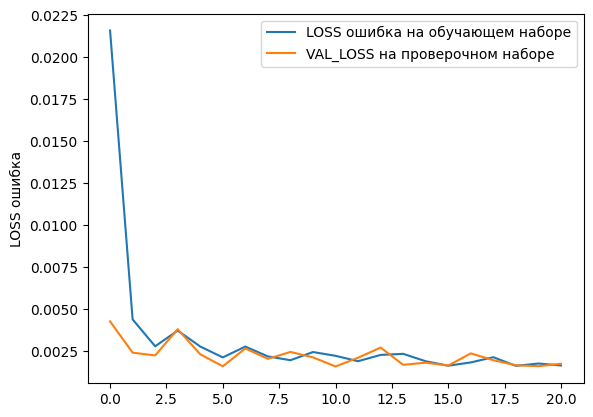

In [19]:
plt.plot(history.history['loss'],
         label='LOSS ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='VAL_LOSS на проверочном наборе')
plt.ylabel('LOSS ошибка')
plt.legend()
plt.show()

## Оценка модели на VAL данных

In [20]:
from utils.estimation import get_scalepred, show_predict, auto_corr

17/17 [==============================] - 0s 7ms/step


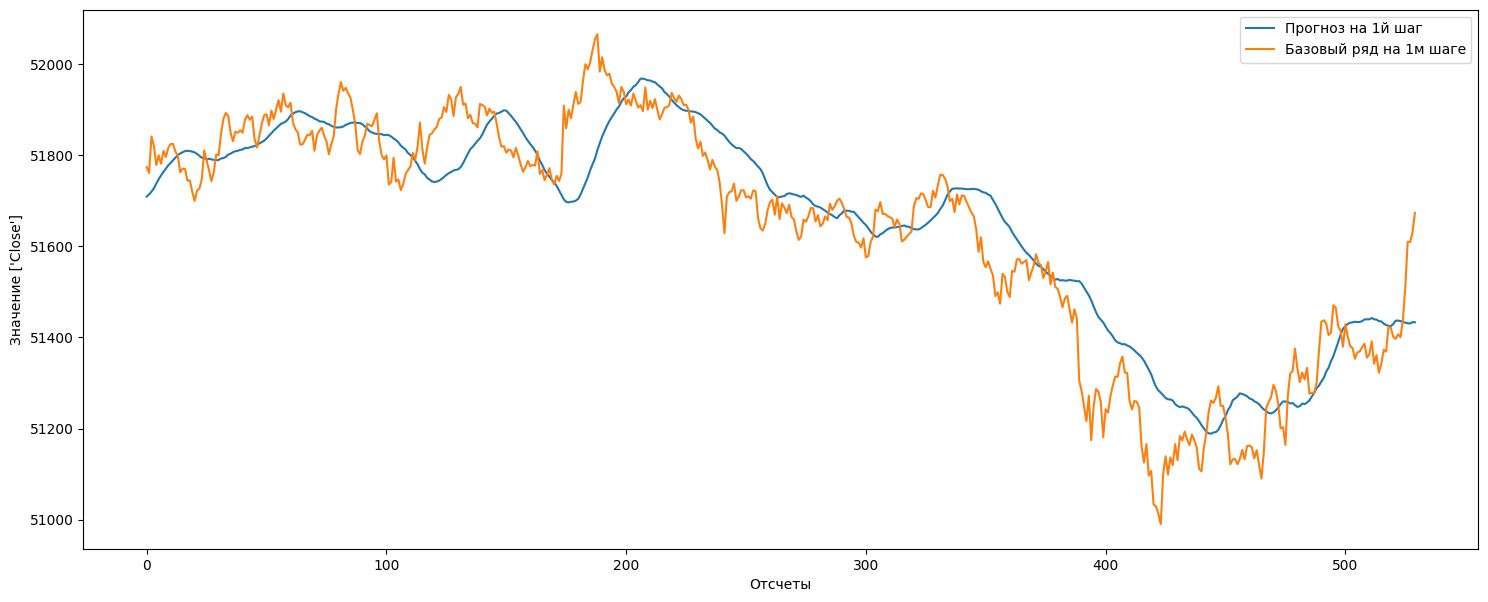

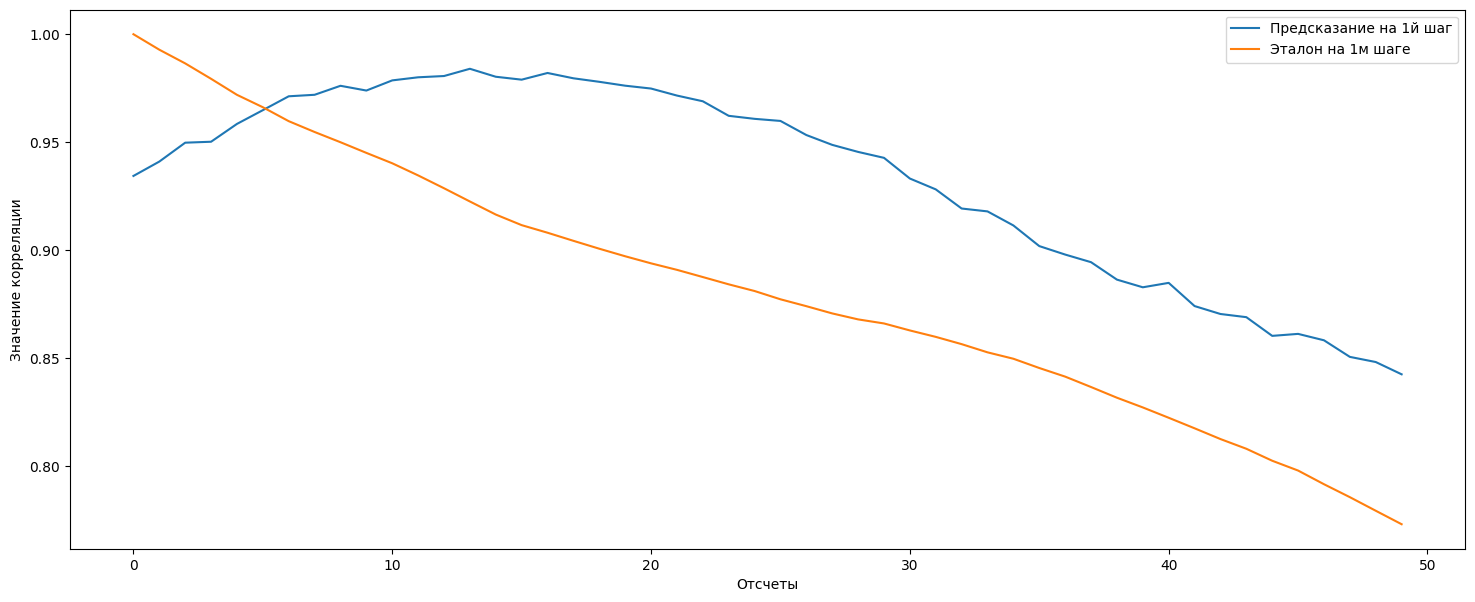

In [22]:
Y_SCAILER = joblib.load("/content/Project_glass/predprice/y_scailer.save")

# Прогнозируем данные текущей сетью
(y_pred_val, y_true_val) = get_scalepred(gen_model, XVAL, YVAL, Y_SCAILER) #Прогнозируем данные

# Отображаем графики
show_predict(0,                    # начало периода
             y_true_val.shape[0],  # конец периода
             [0],                  # по предсказанию на какие шаги отрисовываем
             y_pred_val,           # предчказанные цены
             y_true_val,           # реальные цены
             TARGET_COLS,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([0],             # по предсказанию на какие шаги отрисовываем корреляцию
          50,              # на сколько шагов предсказание
          y_pred_val,      # предчказанные цены
          y_true_val       # реальные цены
          )

## Тест модели на TEST данных

## Готовим производные данных

In [23]:
all_data = pd.read_csv("/content/Project_glass/stock_data/BTCUSDT_1 _min.csv",
                       index_col=0, parse_dates=True )
print(f'Размер данных {all_data.shape}')

TEST_SIZE = 1500 # для теста откусим последние test_size значений
# Тестовая выборка для симуляции торговли в реальном времени
print(f'Тестовый датасет')
TEST_DATASET = all_data[FUTURE-PREDICT_LAG: FUTURE + TEST_SIZE]
print(TEST_DATASET.shape)


Размер данных (8317, 54)
Тестовый датасет
(1505, 54)


### Готовим данные из df_test

In [24]:
# колонки для тренировочной выборки
TRAIN_COLUMNS = BASE_COLS + GLASS_COLS
GLASS = len(GLASS_COLS)

if MAKE_LOG_VOL:
    TEST_DATASET["Volume"] = TEST_DATASET["Volume"].apply(lambda x: np.log(x))

X_MAIN_SCALER = joblib.load("/content/Project_glass/predprice/x_main_scailer.save")
X_GLASS_SCALER = joblib.load("/content/Project_glass/predprice/x_glass_scailer.save")


x_test = TEST_DATASET[TRAIN_COLUMNS].values

x_test_sc = np.zeros_like(x_test)
x_test_sc[:,:-GLASS] = X_MAIN_SCALER.transform(x_test[:,:-GLASS])  # трансформируем x_train
x_test_sc[:,-GLASS:] = X_GLASS_SCALER.transform(x_test[:,-GLASS:])  # трансформируем x_train


print(x_test_sc.shape)
x_test_sc[0]

(1505, 53)


<ipython-input-24-88bc0ba41283>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEST_DATASET["Volume"] = TEST_DATASET["Volume"].apply(lambda x: np.log(x))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array([5.12777110e-01, 5.30849761e-01, 5.59224585e-01, 8.03156241e-01,
       9.81148492e-01, 3.32928467e-01, 2.46189953e-01, 2.76011547e-01,
       3.84728429e-01, 5.69884801e-01, 8.26086957e-01, 8.26923077e-01,
       1.73076923e-01, 7.68037975e-01, 7.95371498e-01, 2.04628502e-01,
       2.69424791e-01, 5.21968014e-02, 3.65033934e-02, 2.31017217e-03,
       2.18156433e-04, 2.71053833e-03, 1.02877507e-02, 1.05207576e-01,
       2.47634639e-03, 5.61413268e-03, 4.30167247e-03, 1.17228464e-02,
       4.94310137e-02, 2.06234675e-02, 2.42760988e-02, 2.99349099e-02,
       1.06172952e-01, 5.20451816e-02, 1.11401650e-01, 1.32959219e-01,
       5.38009083e-02, 4.07870646e-02, 3.22196288e-03, 1.52350576e-02,
       3.11758592e-02, 4.21240090e-03, 2.56698160e-02, 4.14293135e-02,
       1.81756318e-02, 7.31905436e-03, 1.82933279e-01, 1.31749229e-01,
       1.70422807e-01, 1.69260314e-01, 1.08501230e-01, 1.08878697e-01,
       1.83241924e-01])

In [25]:
# Для подготовки y_test на PREDICT_LAG шагов вперед необходимо создать дополнительный датасет
y_test = future_sequence(TEST_DATASET[TARGET_COLS], PREDICT_LAG).squeeze()

# если берем логорифм
if MAKE_LOG_TARGET:
  y_test = np.log(y_test)
print(y_test.shape)

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
y_test_sc = Y_SCAILER.transform(y_test)
print(y_test_sc.shape)

(1501, 5)
(1501, 5)


In [26]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
TestDataGen = TSG(x_test_sc[-y_test_sc.shape[0]:], y_test_sc,        # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_test))  # Размер batch будет равен длине нашей выборки

XTEST, YTEST = [], []
for i in TestDataGen:
  XTEST.append(i[0])
  YTEST.append(i[1])

XTEST = np.array(XTEST)[0]
YTEST = np.array(YTEST)[0]
print(XTEST.shape,YTEST.shape)

(1469, 32, 53) (1469, 5)


### Делаем оценку test данных

46/46 [==============================] - 1s 14ms/step


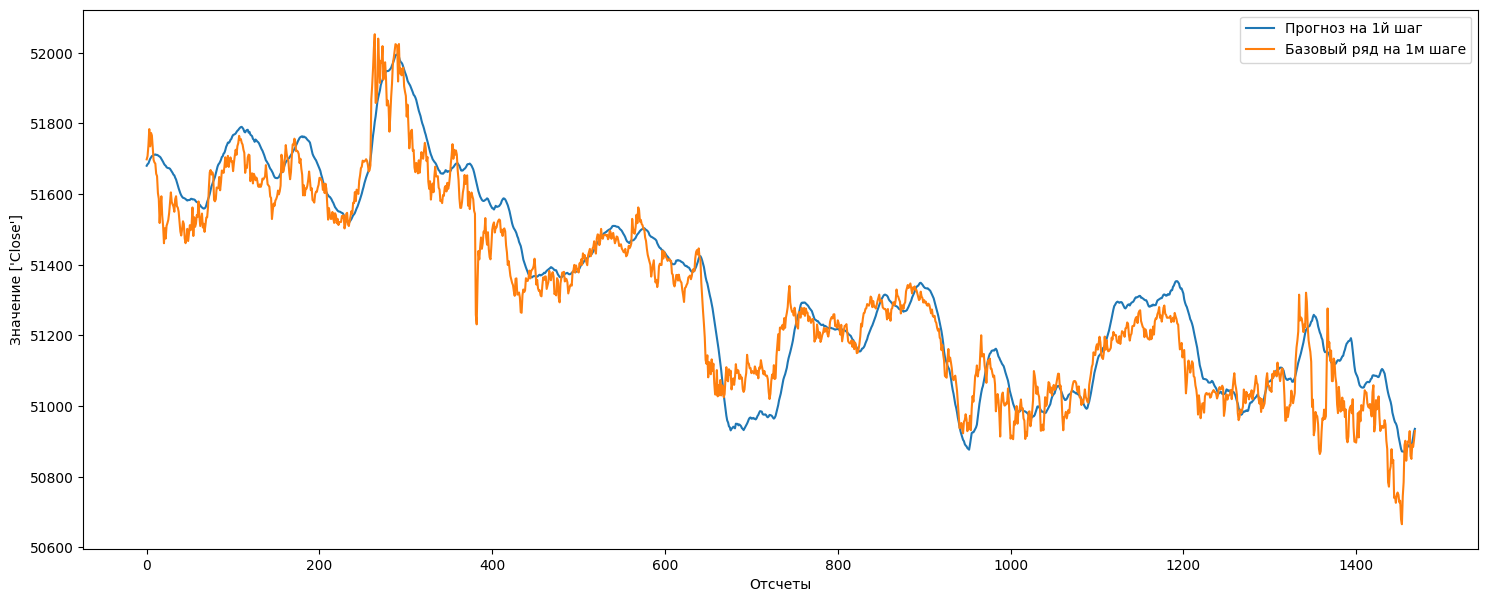

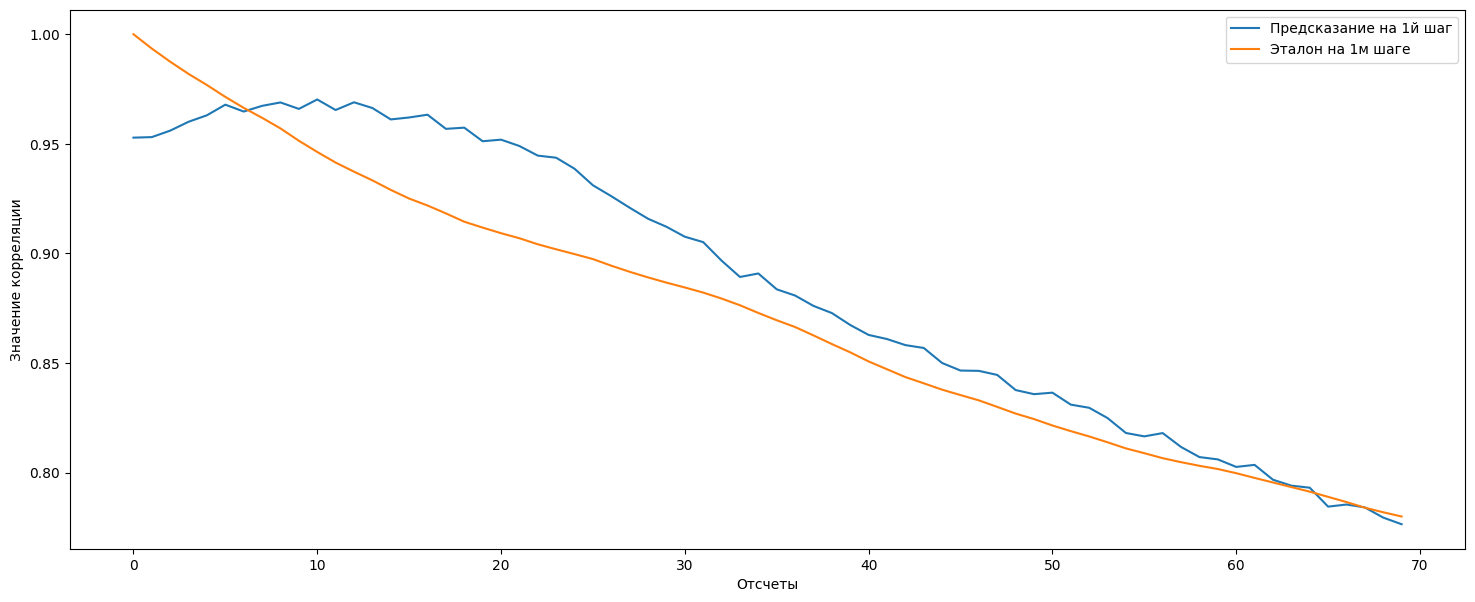

In [27]:
# Прогнозируем данные текущей сетью
(y_pred_test, y_true_test) = get_scalepred(gen_model, XTEST, YTEST,
                                           Y_SCAILER) # Прогнозируем данные


# Отображаем графики
show_predict(0,                     # начало периода
             y_true_test.shape[0],  # конец периода
             [0],                   # по предсказанию на какие шаги отрисовываем
             y_pred_test,           # предчказанные цены
             y_true_test,           # реальные цены
             TARGET_COLS,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([0],              # по предсказанию на какие шаги отрисовываем корреляцию
          70,               # на сколько шагов предсказание
          y_pred_test,      # предчказанные цены
          y_true_test       # реальные цены
          )